# Jax musings


In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Jax as a numpy replacement
Is Jax faster than numpy? Can we just use jax now? How does Jit'ing effect the speed?

## Init random arrays
Note that jax doesn't have stateful random number generation.

In [2]:
def create_numpy_array(seed, shape, dtype):
    """Create numpy random array."""
    return np.random.RandomState(seed).rand(*shape).astype(dtype)

def create_jax_array(seed, shape, dtype):
    """Create jax random array."""
    seed = jax.random.PRNGKey(42)
    return jax.random.uniform(seed, shape).astype(dtype)

## Simple tests
Run some very simple linear algebra tests

In [3]:
def timeit(func, ar, *args, **kwargs):
    """Generic timing function"""
    if isinstance(ar, jnp.ndarray): 
        # jax cheats, need to block until ready because it is async.
        out = %timeit -o func(ar, *args, **kwargs).block_until_ready()
    else:
        out = %timeit -o func(ar, *args, **kwargs)
    
    return out.best



def run_timining_loop(sizes, np_func, jx_func, *args):
    """Run a timing loop for jax and numpy."""
    df = pd.DataFrame(columns=["jax", "numpy", "rows", "columns"])
    df['rows'] = [x[0] for x in sizes]
    df['columns'] = [x[1] for x in sizes]
    for num, size in enumerate(sizes):
        nar = create_numpy_array(42, size, np.float32)
        jar = create_jax_array(42, size, np.float32)
        df.loc[num, "numpy"] = timeit(np_func, nar, *args)
        df.loc[num, "jax"] = timeit(jx_func, jar, *args)
    return df



def plot_timing_result(df, ax=None, title=''):
    """Function to make a log-log plot of timing"""
    if ax is None:
        _, ax = plt.subplots(1, 1)
    elements = df['rows'] * df['columns']
    # plot lines
    ax.loglog(elements, df['numpy'], label='numpy', color='blue')
    ax.loglog(elements, df['jax'], label='jax', color='red')
    # plot dots showing test locations
    ax.loglog(elements, df['numpy'], 'x', color='blue')
    ax.loglog(elements, df['jax'], 'x', color='red')

    ax.legend()
    ax.set_xlabel('Array Size (# Elements)')
    ax.set_ylabel('Time (s)')
    ax.set_title(title)
    return ax

### axpy

In [4]:
def axpy_self(ar, scalar):
    return ar * scalar + ar

In [5]:
size_long = (1, 10, 100, 1_000, 10_000, 100_000, 1_000_000)
size_short = 100
sizes = [(x, size_short) for x in size_long]

In [6]:
%%capture
axpy_df = run_timining_loop(sizes, axpy_self, axpy_self, 1)

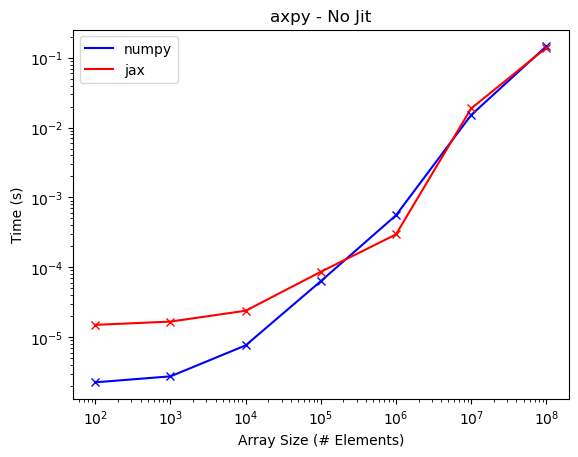

In [7]:
plot_timing_result(axpy_df, title='axpy - No Jit');

In [8]:
%%capture
axpy_df_jit = run_timining_loop(sizes, axpy_self, jax.jit(axpy_self), 1)

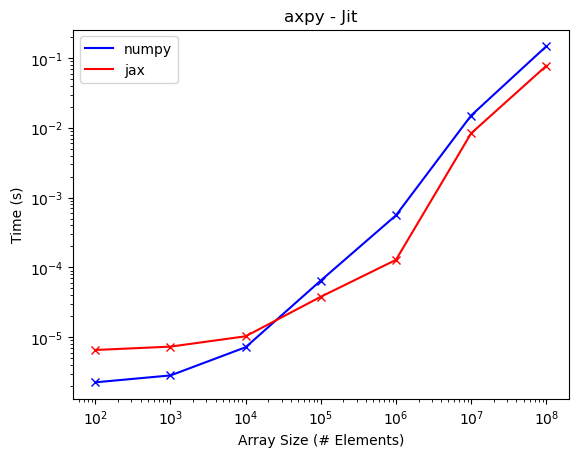

In [9]:
plot_timing_result(axpy_df_jit, title='axpy - Jit');

### multi_add

In [10]:
def pow_add(ar):
    return ar + ar**2 + ar**3 + ar**4

In [11]:
%%capture
pow_add_df = run_timining_loop(sizes, pow_add, pow_add)

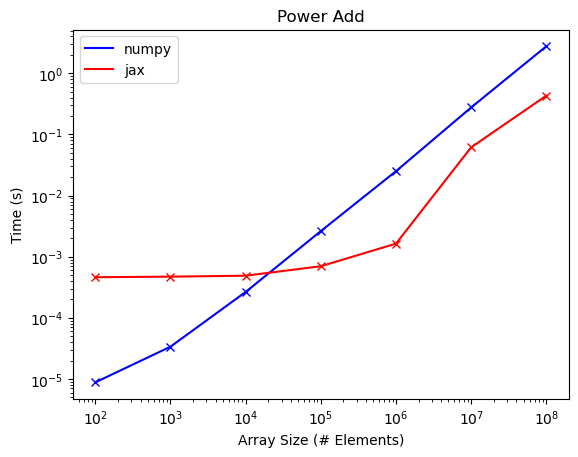

In [12]:
plot_timing_result(pow_add_df, title='Power Add');

In [13]:
%%capture
jit_pow_add = jax.jit(pow_add)
pow_add_jit = run_timining_loop(sizes, pow_add, jit_pow_add)

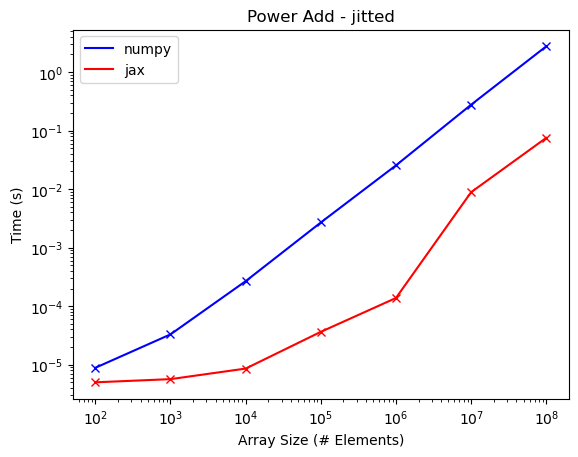

In [14]:
plot_timing_result(pow_add_jit, title='Power Add - jitted');